In [ ]:
%matplotlib inline
%load_ext rpy2.ipython
import os
import scipy

GIMME_DIR = "/home/isaac/gimmeSAD"
SIMOUT_DIR = os.path.join(GIMME_DIR, "simout/")

os.chdir(GIMME_DIR)
import gimmeSAD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
import glob
import sys
import ast
import math
import subprocess
import fastkde
from scipy.stats import expon
from decimal import Decimal

## Define the function to draw the plots

In [3]:
def plot_per_lambda(lambda_dists):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300)
    axarr = [a for b in axarr for a in b]


    for k, ax in zip(sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k))
        coltimes = lambda_dists[k]
        ax.hist(coltimes)
        ax.set_ylabel('N Species', color='b')
        ax.set_xlabel('Colonization Time', color='b')
        ax.get_yaxis().set_ticks([])
        ax.get_xaxis().set_ticks([])
        ## Super annoying
        #ax.get_xaxis().set_ticks(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5)))
        #ax.set_xticklabels(np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/6)))#, fontsize=7)
        data = sorted(coltimes)
        loc, sc = expon.fit(data, floc=0)
        print("{} {}".format(k, sc))
        rv = expon(scale=sc)
        x = np.linspace(0, max(data), 100)

        ax1 = ax.twinx()
        ax1.plot(x, rv.pdf(x), color='black')
        ax1.get_yaxis().set_ticks([])
    plt.tight_layout()

In [4]:
## Funcs for pretty printing scientific notation
def fexp(number):
    (sign, digits, exponent) = Decimal(number).as_tuple()
    return len(digits) + exponent - 1

def fman(number):
    return Decimal(number).scaleb(-fexp(number)).normalize()

def format_label_string_with_exponent(ax, axis="both"):

    ticklabels = []
    if axis == "x":
        ticklabels = ax.get_xticklabels()
    else:
        ticklabels = ax.get_yticklabels()
    print([x.get_text() for x in ticklabels])
    labs = []
    for x in ticklabels:
        try:
            x = float(x.get_text())
            print(fexp(x), fman(x))
            ## Only update the labels if the numbers are ugly
            if (x < 0.001):
                d = fman(x)
                labs.append(round(d, 2))
            else:
                labs.append(x)
        except Exception as inst:
            labs.append("")
            #print(inst)
            pass
    if axis == "x":
        ax.set_xticklabels(labs)
    else:
        ax.set_yticklabels(labs)

def plot_pidxy_per_lambda(lambda_dists, xaxis_label="generic xaxis", dpi=300, ylabel="N Species", nbins=10, zoom_x=5, \
                          normed=True, sharex=True, sharey=False, semilogy=False, semilogx=False, do_expon=True,\
                          suptitle="Generic Plot Title"):
    f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=dpi, sharex=sharex, sharey=sharey)
    if semilogy == True:
        plt.yscale('log', nonposy='clip', log=2)
    if semilogx == True:
        plt.xscale('log', nonposy='clip', log=10)
    axarr = [a for b in axarr for a in b]


    for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
        ax.set_title(u"Λ = {}".format(k), fontsize=11)
        coltimes = lambda_dists[k]
        ax.hist(coltimes, color="red", bins=nbins, normed=normed)

        x0, x1 = ax.get_xlim()
        ax.set_xlim(0, x1/zoom_x)

        if do_expon:
            data = sorted(coltimes)
            loc, sc = expon.fit(data, floc=0)
            ## Don't print the scaling factor
            print("{} {}".format(k, sc))
            rv = expon(scale=sc)
            x = np.linspace(0, max(data), 100)
            ax1 = ax.twinx()
            ax1.plot(x, rv.pdf(x), color='black')
            ax1.get_yaxis().set_ticks([])
            ax1.set_xlim(xmin=0)
            ax1.set_ylim(ymin=0)
            x0, x1 = ax.get_xlim()
            ax.set_xlim(0, x1/zoom_x)

    
    f.canvas.draw()
    print([x.get_text() for x in axarr[0].get_xticklabels()])
    for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
        ## If you want axis labels per subplot
        if sharey:
            if i in [0, 3]:
                #format_label_string_with_exponent(axarr[i], axis='y')
                ax.set_ylabel(ylabel)
        if sharex:
            if i in [3, 4, 5]:
                #format_label_string_with_exponent(axarr[i], axis='x')
                ax.set_xlabel(xaxis_label)

    f.text(0.5, 0.01, xaxis_label, ha='center', fontsize=13)
    f.text(0.03, 0.5, ylabel, va='center', rotation='vertical', fontsize=13)
    plt.suptitle(suptitle, y=.9999, fontsize=15)
    plt.subplots_adjust(hspace=.5, wspace=.4)



## Cell for testing mods to the plotting function
The next cell won't run until you've actually loaded some data

[u'0', u'5000', u'10000', u'15000']


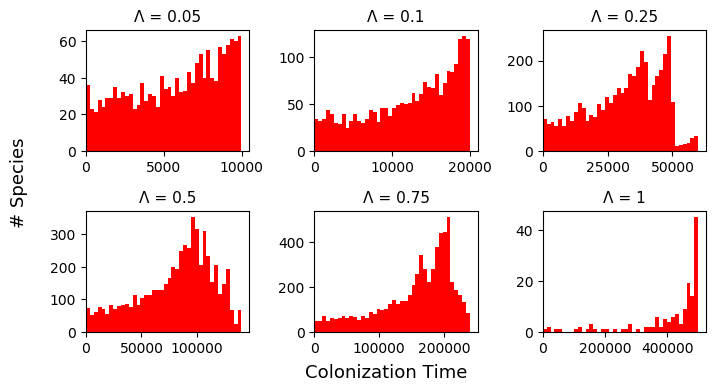

In [16]:
ldists = {}
for x in lambda_dists.keys():
    ldists[x] = lambda_dists[x]#[:10000]
plot_pidxy_per_lambda(ldists, suptitle="", ylabel="# Species", xaxis_label="Colonization Time",\
                      dpi=100, nbins=40, zoom_x=1, normed=False, sharex=False, sharey=False, do_expon=False,\
                     semilogy=False)

# **Colonization times**
## Gather all the colonization time vectors for all the simulations

In [24]:

files = glob.glob(SIMOUT_DIR + "*5000*/coltimes.txt")
dat = []
for f in files:
    lines = open(f).readlines()
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = [float(x.translate(None, "[],")) for x in line.strip().split()]
            ## Convert colonization time, which is recorded as the timestep of 
            ## colonization, to absolute time, basically subtract each coltime
            ## per species from the "current" time
            #l = [l[0]] + [l[1] - x for x in l[2:]]
            ## Don't do this other shit cuze we already do this in gimmesad
            l = [l[0]] + [x for x in l[2:]]
            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))


Processed ntimepoints 988


## Now we have to go through all the data and pick out timepoints that are "close"
## to our timepoints of interest

Got n coltimes per lambda:
0.25 - 3826	0.5 - 10309	0.05 - 3954	0.1 - 3615	1 - 24038	0.75 - 10296	

[u'0', u'5000', u'10000', u'15000']


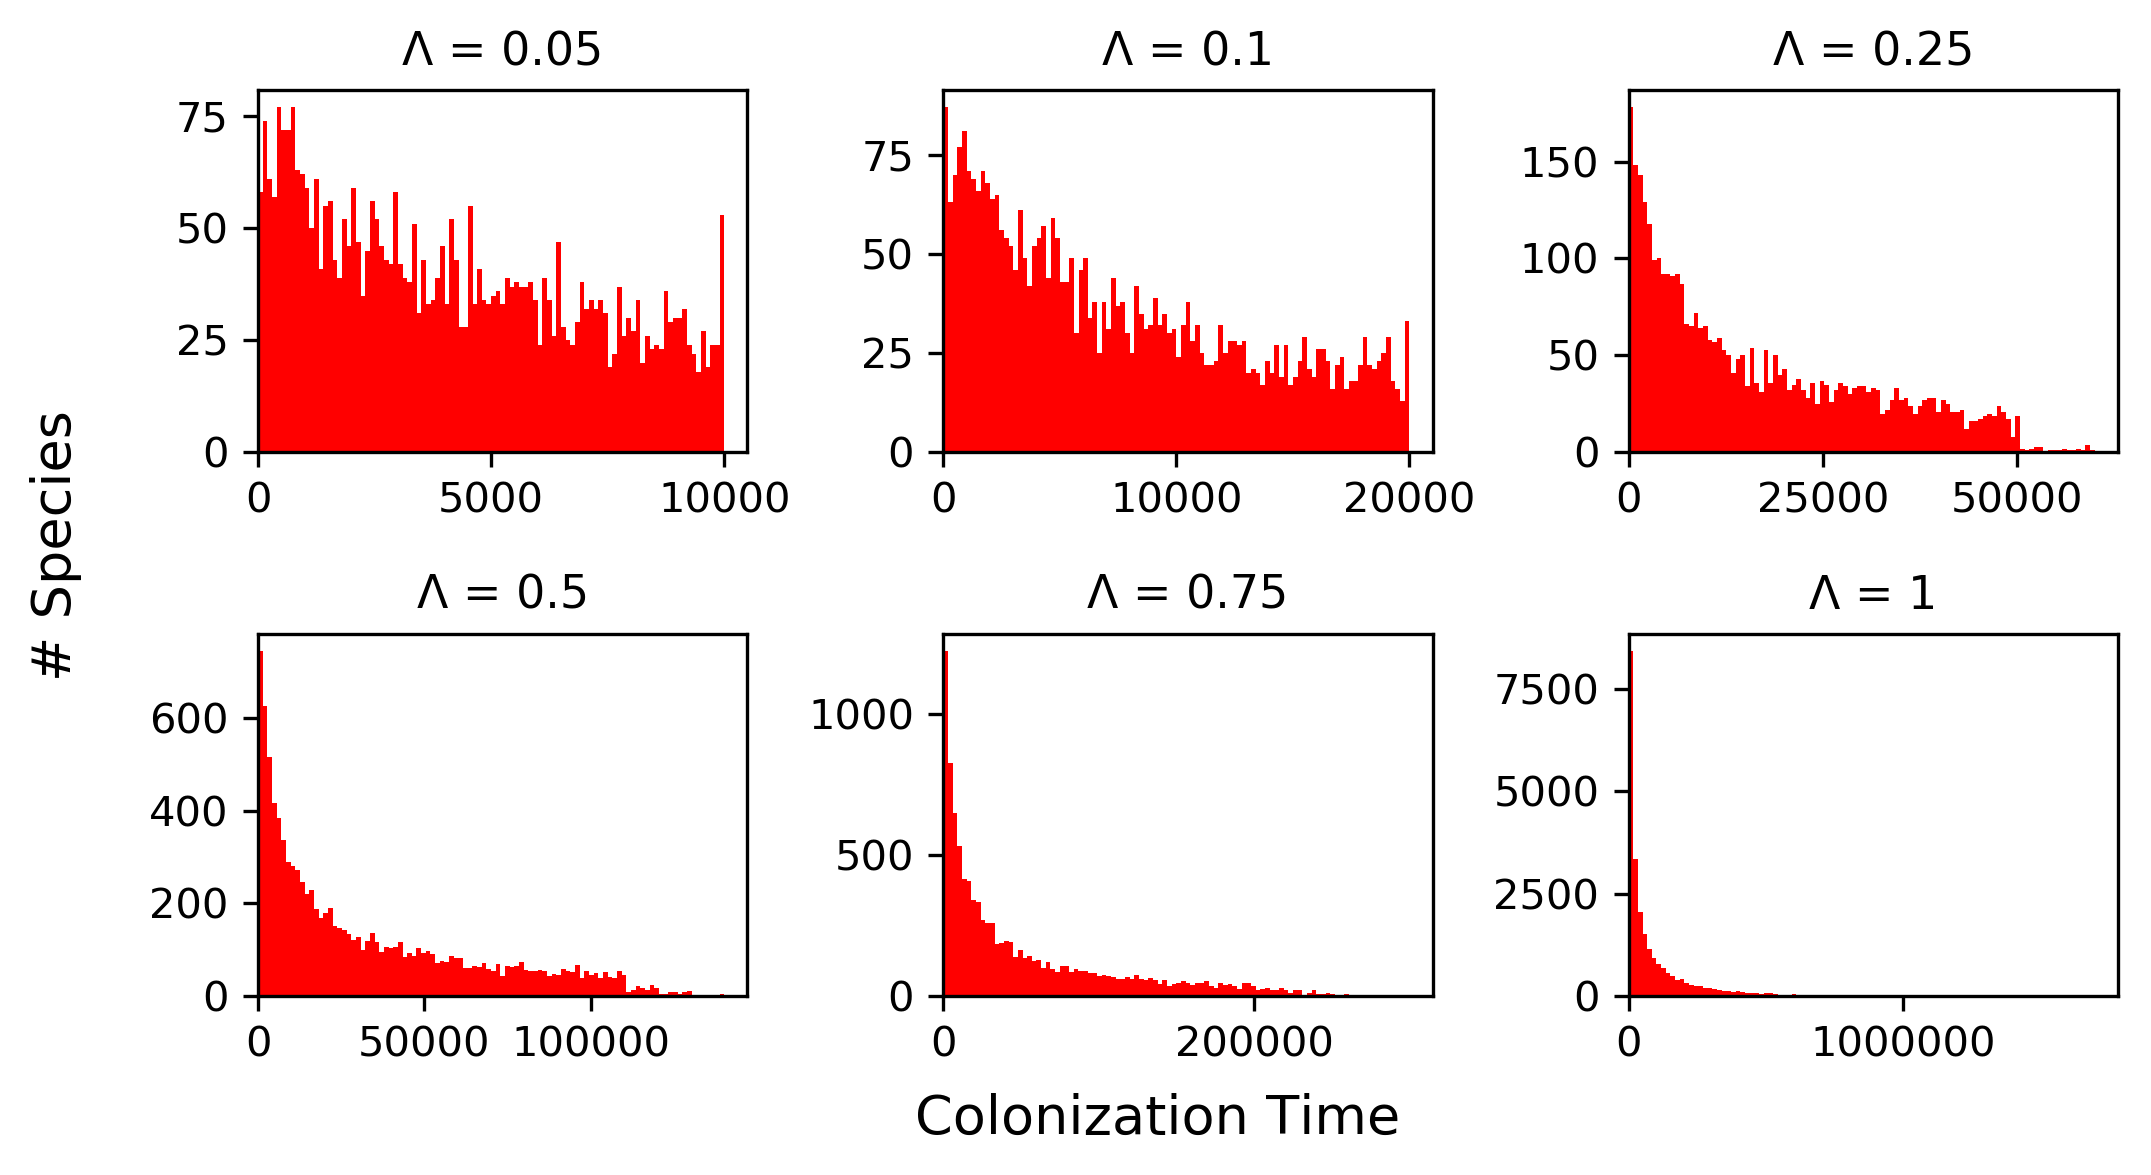

In [26]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend(line[2:])
    lambda_dists[percent] = coltimes[:100000]
    ## In case you want to just randomly subsample
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),
print("\n")
## Plot
plot_pidxy_per_lambda(lambda_dists, suptitle="", nbins=100, \
                      normed=False, sharey=False, sharex=False, zoom_x=1, do_expon=False,\
                     semilogy=False, dpi=300, xaxis_label="Colonization Time", ylabel="# Species")

# abundances

In [27]:
def unpack_abundances(my_abund):
    """ Unpacks packed abundances in my form (tuples), into just raw species abundances """
    raw_abund = []
    for ab in my_abund:
        raw_abund.extend([ab[0]] * ab[1])
    return raw_abund

## quicksort stolen from the internet
def qsort(arr):
     if len(arr) <= 1:
          return arr
     else:
          return qsort([x for x in arr[1:] if x[0]<arr[0][0]])\
                    + [arr[0]] + qsort([x for x in arr[1:] if x[0]>=arr[0][0]])

In [232]:
files = glob.glob(SIMOUT_DIR + "*5000*/abundances.txt")
dat = []
for f in files:
    lines = open(f).readlines()
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = line.strip().split()
            d = float(l[0])
            abund = ast.literal_eval(line.split("OrderedDict")[1])
            abund = qsort(abund)
            abund = unpack_abundances(abund)
            new_lines.append([d] + abund)
        except Exception as inst:
            pass
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))


Processed ntimepoints 3290


Got n coltimes per lambda:
0.25 - 8640	0.5 - 11160	0.05 - 17272	0.1 - 13489	1 - 1988	0.75 - 6791	

0.05 12.7373784159
0.1 20.0163095856
0.25 32.4074074074
0.5 38.082437276
0.75 39.0222353114
1 37.7263581489
[u'0', u'50', u'100', u'150']


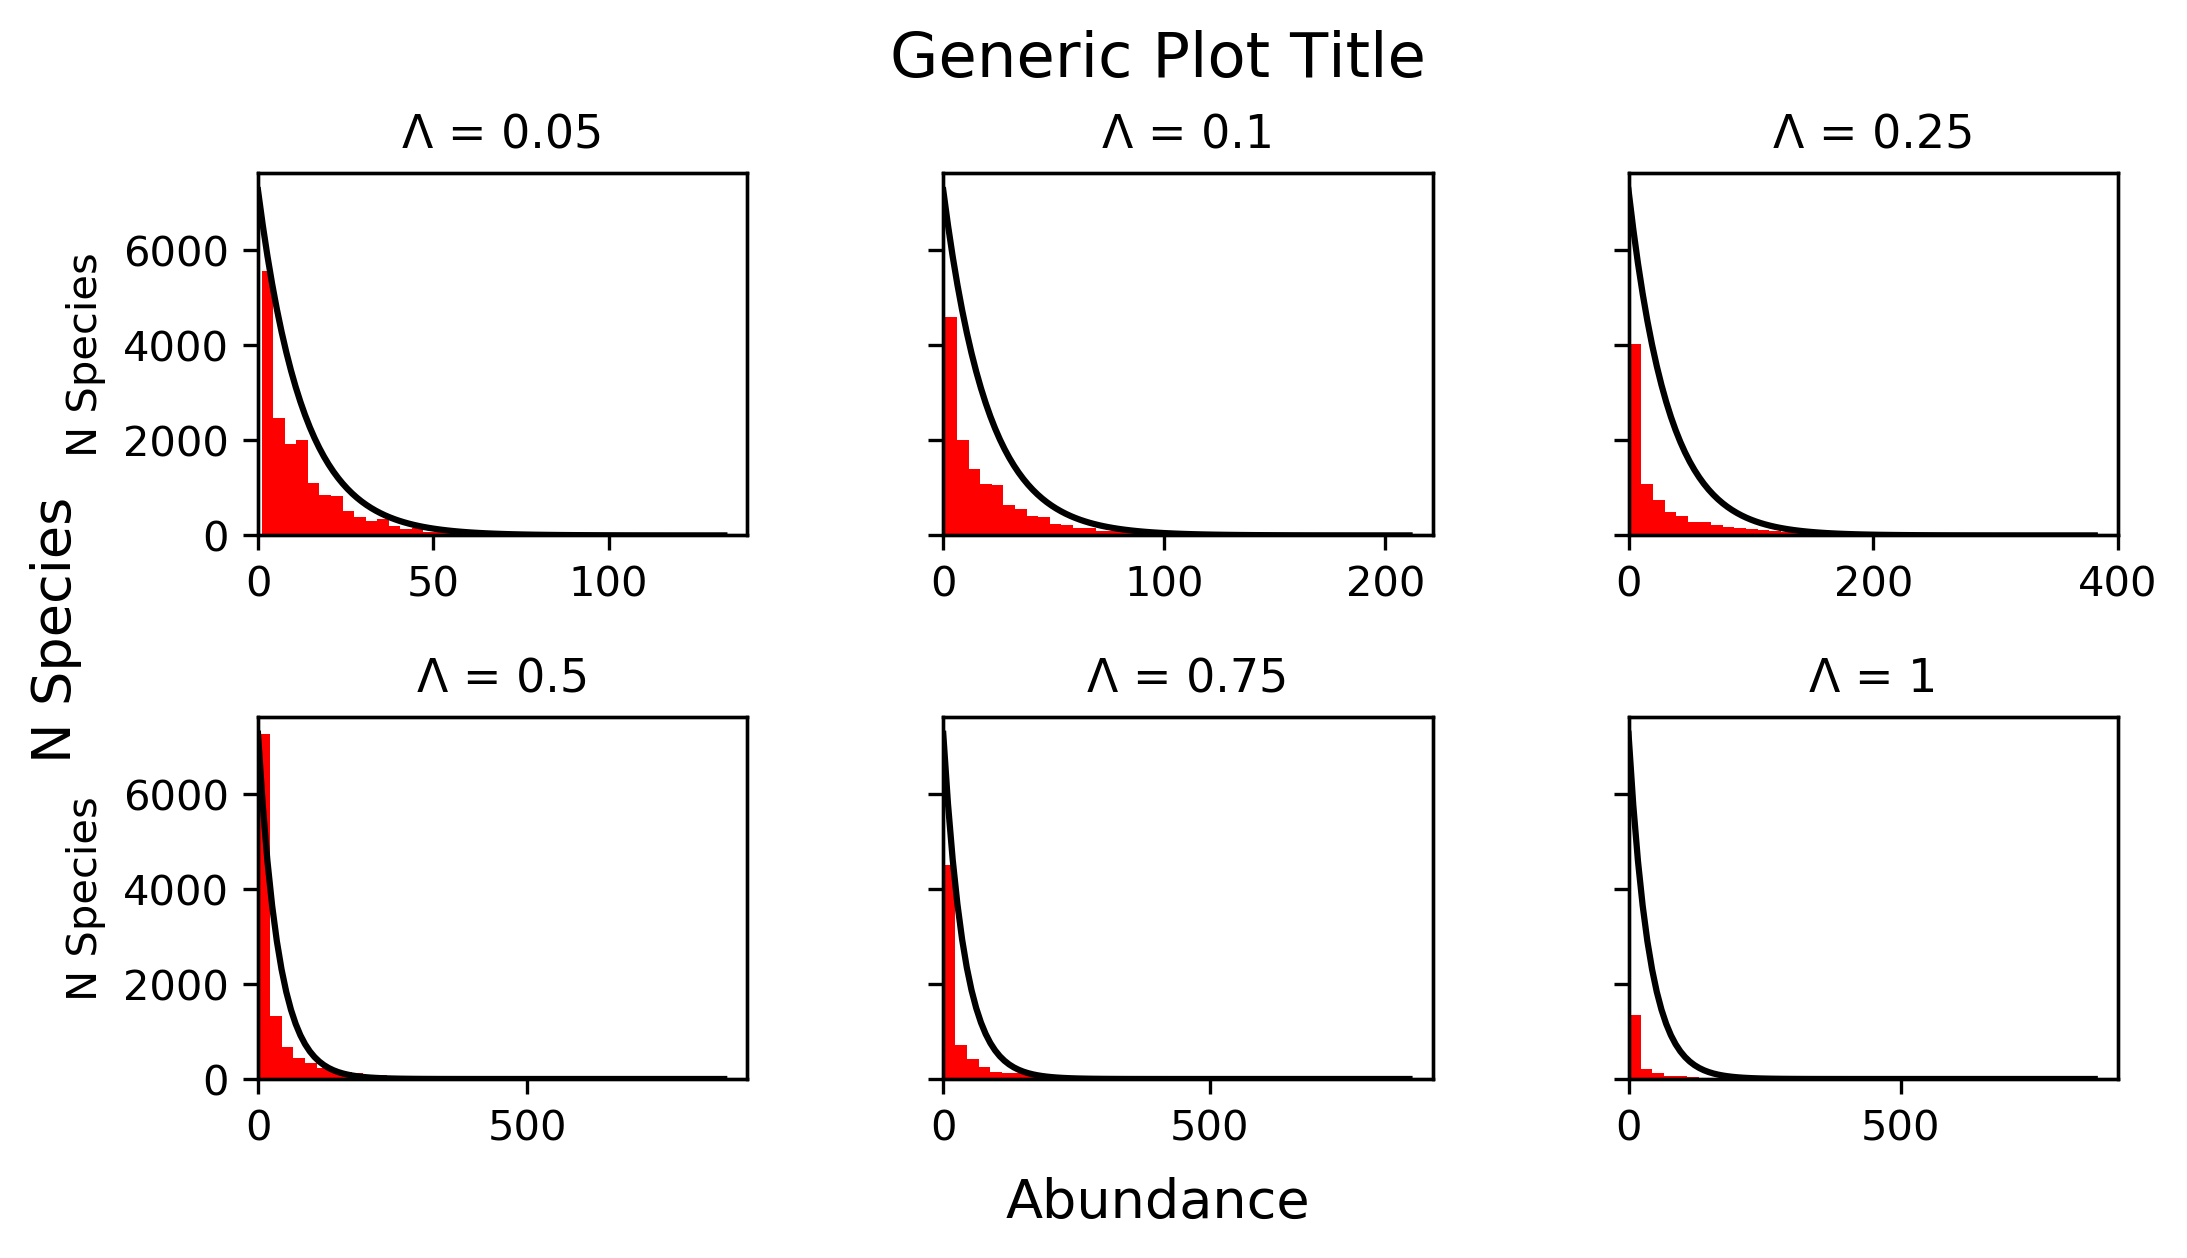

In [233]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend(line[1:])
    lambda_dists[percent] = coltimes#[:27000]
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),
print("\n")
## Plot
plot_pidxy_per_lambda(lambda_dists, "Abundance", nbins=40, normed=False, zoom_x=1, \
                      sharex=False, sharey=True, semilogx=False, semilogy=False, do_expon=True)

# Do pi and Dxy
## Gather all the pi and dxy values vectors for all the simulations

Useful pub with distribution of pi across the tree of life:
http://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.1001388

pi ranges between 0.01% and 10%. Arthropods are typically in the 1-5% range.

In [454]:
files = glob.glob(SIMOUT_DIR + "*000*/pidxy.txt")
pi_dat = []
dxy_dat = []
for f in files:
    lines = open(f).readlines()
    tmp_pi = []
    tmp_dxy = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            ldat = line.strip().split()
            try:
                l = [float(ldat[0])] + [float(x.translate(None, "[],")) for x in ldat[2:]]
            except:
                print(ldat),
            if "pi" in ldat:
                tmp_pi.append(l)
            else:
                tmp_dxy.append(l)
        except Exception as inst:
            print(inst)
    pi_dat.extend(tmp_pi)
    dxy_dat.extend(tmp_dxy)
print("Processed ntimepoints {} {}".format(len(pi_dat), len(dxy_dat)))
#print(dxy_dat[:1])


['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] ['0.0', 'pi', '[]'] ['0.0', 'dxy', '[]'] Processed ntimepoints 60462 60459


## Now we have to go through all the data and pick out timepoints that are "close"
## to our timepoints of interest

In [450]:
time_tolerance = 0.024
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
maxsamps = 20000
pi_dists = {}
dxy_dists = {}
## Dict for storing distributions per timepoint
for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
    lambda_dists = {perc:[] for perc in sampling_lambdas}
    ## Ineffecient but i don't care
    for percent in sampling_lambdas:
        coltimes = []
        for line in dat:
            ## If the difference between the lambda for each line
            ## is close enough to the sampling lambda we want then keep the coltimes
            if abs(line[0] - percent) < time_tolerance:
                m = np.array(line[2:])
                #p = m[m<0.2]
                #p = p[p>=0]
                coltimes.extend(m)
        lambda_dists[percent] = coltimes[:maxsamps]
    print("Got # {} per lambda:".format(g))
    for k,v in lambda_dists.items():
        print("{} - {}\t".format(k, len(v))),
    print("\n")
    if "pi" in g:
        pi_dists = lambda_dists
    else:
        dxy_dists = lambda_dists

Got # pi per lambda:
0.25 - 20000	0.5 - 20000	0.05 - 20000	0.1 - 20000	1 - 2083	0.75 - 17518	

Got # dxy per lambda:
0.25 - 20000	0.5 - 20000	0.05 - 20000	0.1 - 20000	1 - 2083	0.75 - 17518	



In [169]:
## These plots are kind of useless
if True:
    pass
    ## Plot
    #if "pi" in g:
    #    plot_pidxy_per_lambda(lambda_dists, u"Nucleotide diversity (π)", nbins=40, normed=False, sharey=True, \
    #                          zoom_x=.75, semilogx=False, semilogy=False, do_expon=False)
    #else:
    #    plot_pidxy_per_lambda(lambda_dists, r"Absolute divergence ($D_{xy}$)", nbins=40, normed=False, sharey=True, \
    #                          zoom_x=1, semilogx=False, semilogy=False, do_expon=False)

[0.0, 0.0, 0.00097465886939571156, 0.0, 0.0, 0.0, 0.0, 0.00081871345029239765, 0.0, 0.00093567251461988308, 0.0, 0.00035087719298245617, 0.00062378167641325539, 0.00062378167641325539, 0.0, 0.0, 0.0, 0.00035087719298245617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00093567251461988308, 0.0, 0.00035087719298245617, 0.0, 0.00081871345029239765, 0.0, 0.00035087719298245617, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00035087719298245617, 0.0, 0.0, 0.0, 0.00070175438596491234, 0.0, 0.0, 0.0, 0.0, 0.00035087719298245617, 0.0]
[0.012631578947368414, 0.005263157894736842, 0.015964912280701755, 0.052807017543859643, 0.11438596491228079, 0.28298245614035106, 0.035614035087719306, 0.013333333333333332, 0.02140350877192981, 0.026666666666666651, 0.0412280701754386, 0.0066666666666666662, 0.028245614035087723, 0.019473684210526313, 0.006666666666666668, 0.0036842105263157898, 0.031052631578947366, 0.11859649122807024, 0.0866666666666

# Now look at the joint pi/dxy 2d histograms through time

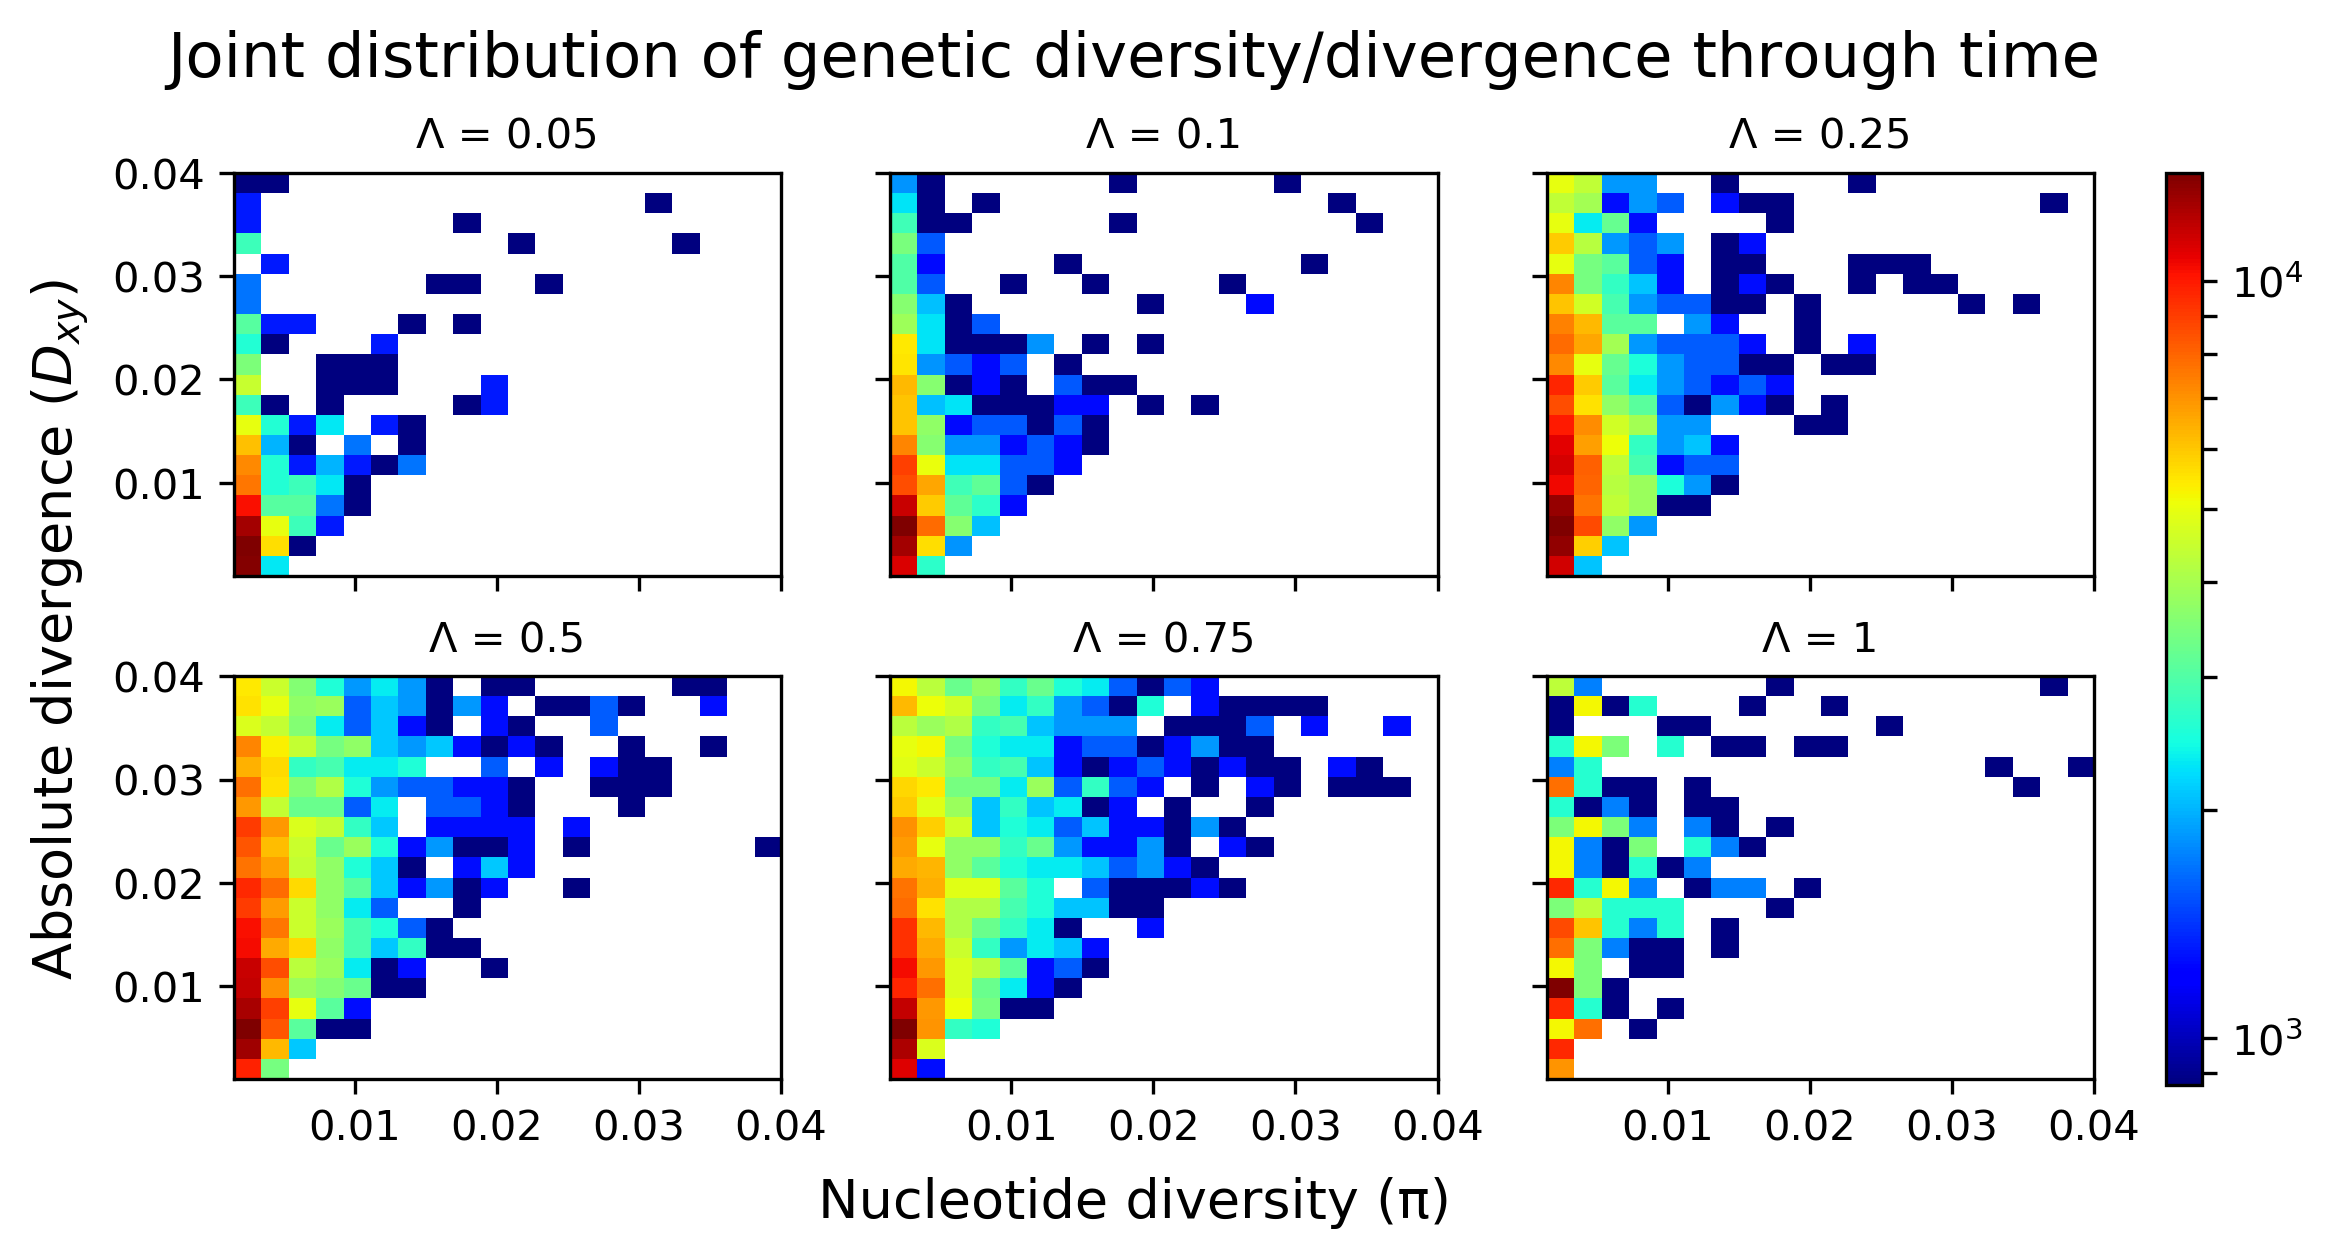

In [451]:
from matplotlib.colors import LogNorm
f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=True, sharey=True)
axarr = [a for b in axarr for a in b]
cmap="jet"
rang=[[0.0015, 0.04], [0.001, 0.04]]
for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
    try:
        ax.set_title(u"Λ = {}".format(k), fontsize=10)
        hist, _, _, im = ax.hist2d(pi_dists[k], dxy_dists[k], bins=20, range=rang, cmap=cmap, norm=LogNorm(), normed=True, )
    except Exception as inst:
        print(i, k, inst)
f.text(0.5, 0.01, u"Nucleotide diversity (π)", ha='center', fontsize=13)
f.text(0.04, 0.5, r"Absolute divergence ($D_{xy}$)", va='center', rotation='vertical', fontsize=13)
plt.suptitle("Joint distribution of genetic diversity/divergence through time", y=.9999, fontsize=15)
plt.subplots_adjust(hspace=.25)

cb_ax = f.add_axes([0.93, 0.12, 0.015, 0.76])
cbar = f.colorbar(im, cax=cb_ax)


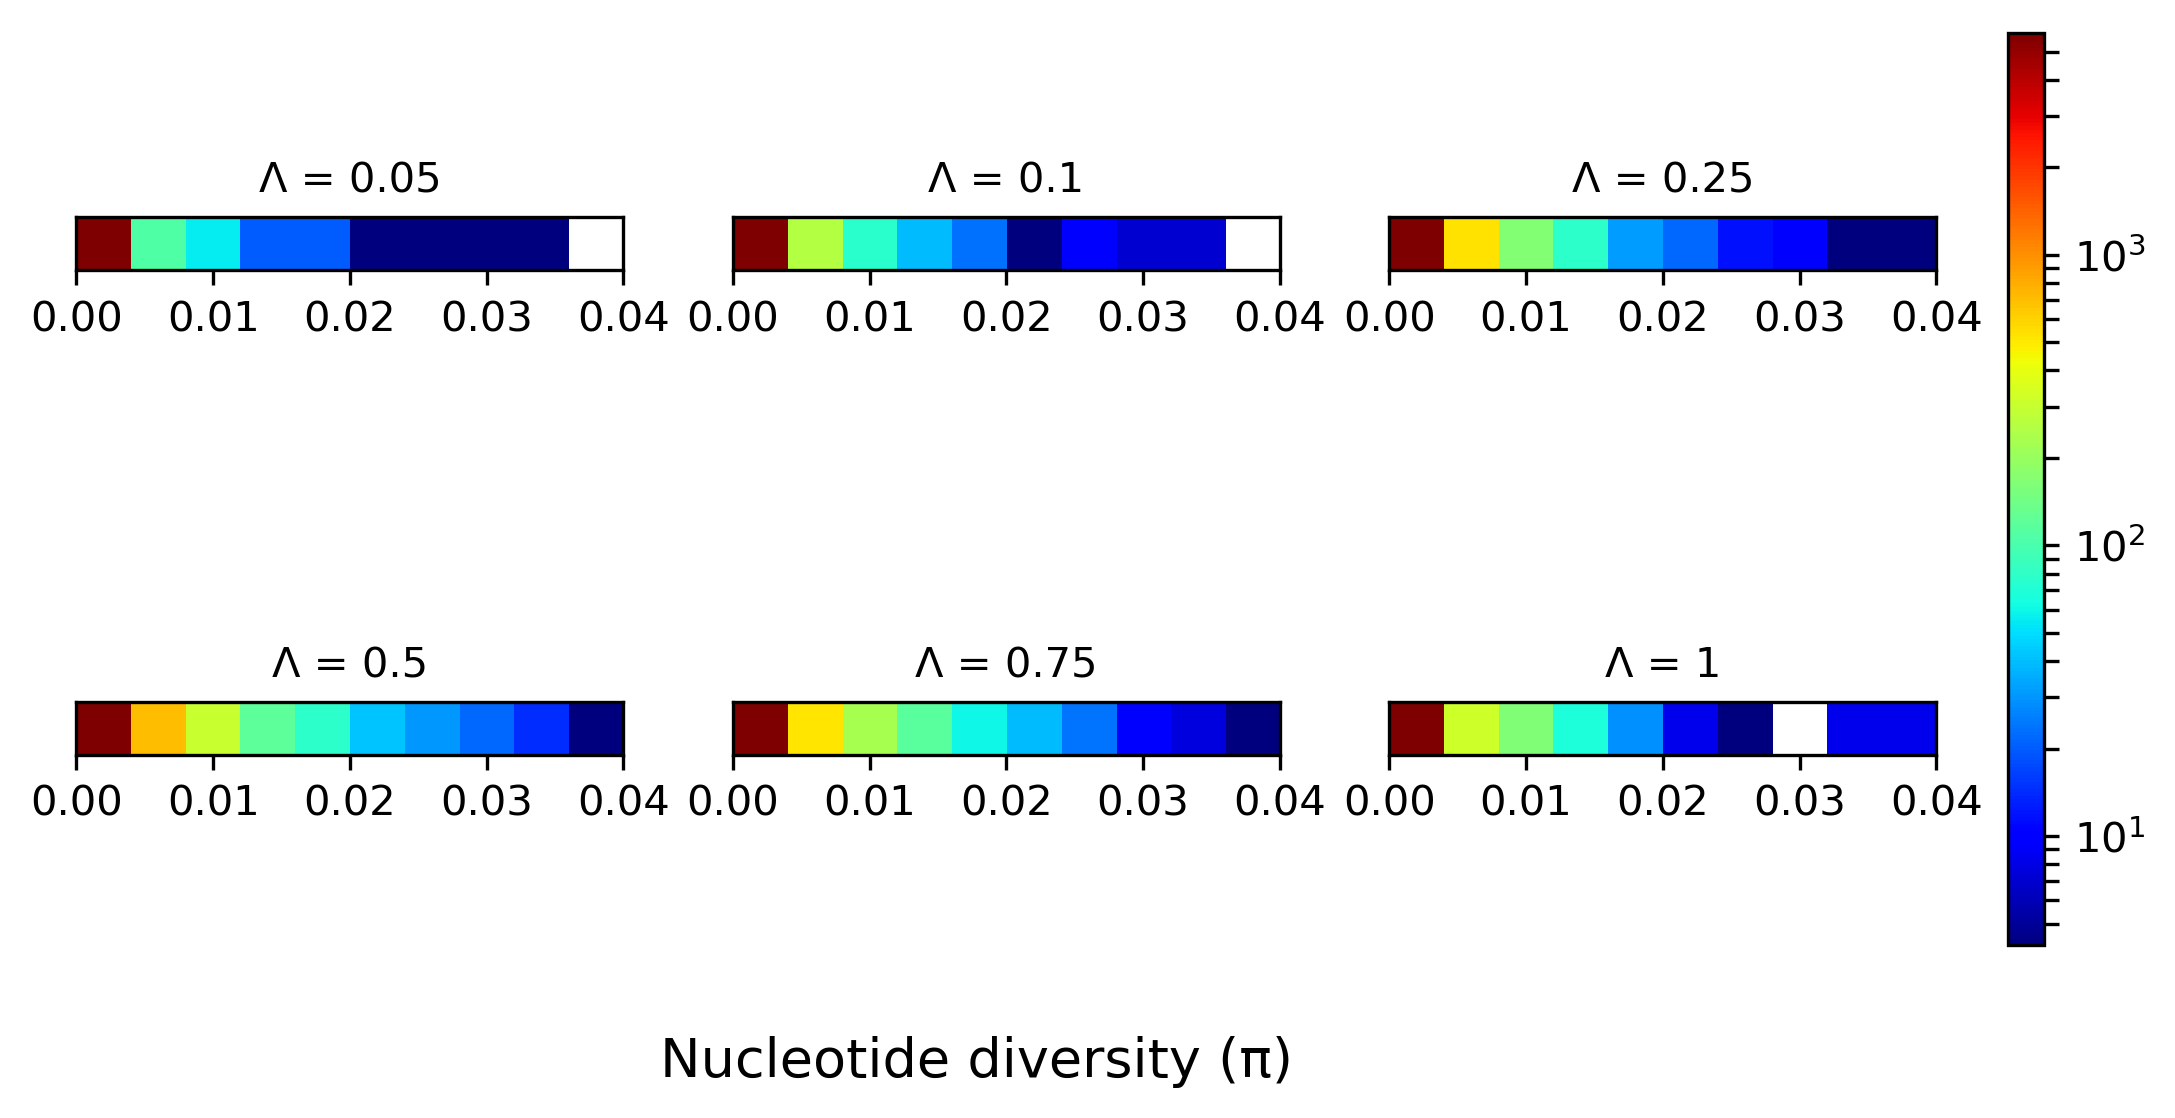

In [452]:
from matplotlib.colors import LogNorm
f, axarr = plt.subplots(2, 3, figsize=(8,4), dpi=300, sharex=False, sharey=True)
axarr = [a for b in axarr for a in b]
cmap="jet"
rang=[[0, 0.04], [0.001, 0.04]]
for i, k, ax in zip(xrange(0,6), sampling_lambdas, axarr):
    try:
        ax.set_title(u"Λ = {}".format(k), fontsize=10)
        hist, _, _, im = ax.hist2d(pi_dists[k], dxy_dists[k], bins=[10, 1], range=rang, cmap=cmap, norm=LogNorm(), normed=True, )
        ax.set_aspect(0.1)
        ax.set_yticks([])
    except Exception as inst:
        print(i, k, inst)
f.text(0.5, 0.01, u"Nucleotide diversity (π)", ha='center', fontsize=13)
plt.subplots_adjust(hspace=.15)

cb_ax = f.add_axes([0.93, 0.12, 0.015, 0.76])
cbar = f.colorbar(im, cax=cb_ax)


# Now do extinction times, this is "life span" of local species

In [46]:
files = glob.glob(SIMOUT_DIR + "*5000*/extinction_times.txt")
dat = []
for f in files:
    lines = open(f).readlines()
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            l = [float(x.translate(None, "[],")) for x in line.strip().split()]

            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))


Processed ntimepoints 1259


Got n exttimes per lambda:
0.25 - 5940	0.5 - 3844	0.05 - 4222	0.1 - 4534	1 - 195680	0.75 - 6952	

0.05 2198.12624349
0.1 4342.86656374
0.25 8086.0526936
0.5 11931.5801249
0.75 16638.3742808
1 21109.8659597
[u'0', u'5000', u'10000', u'15000']


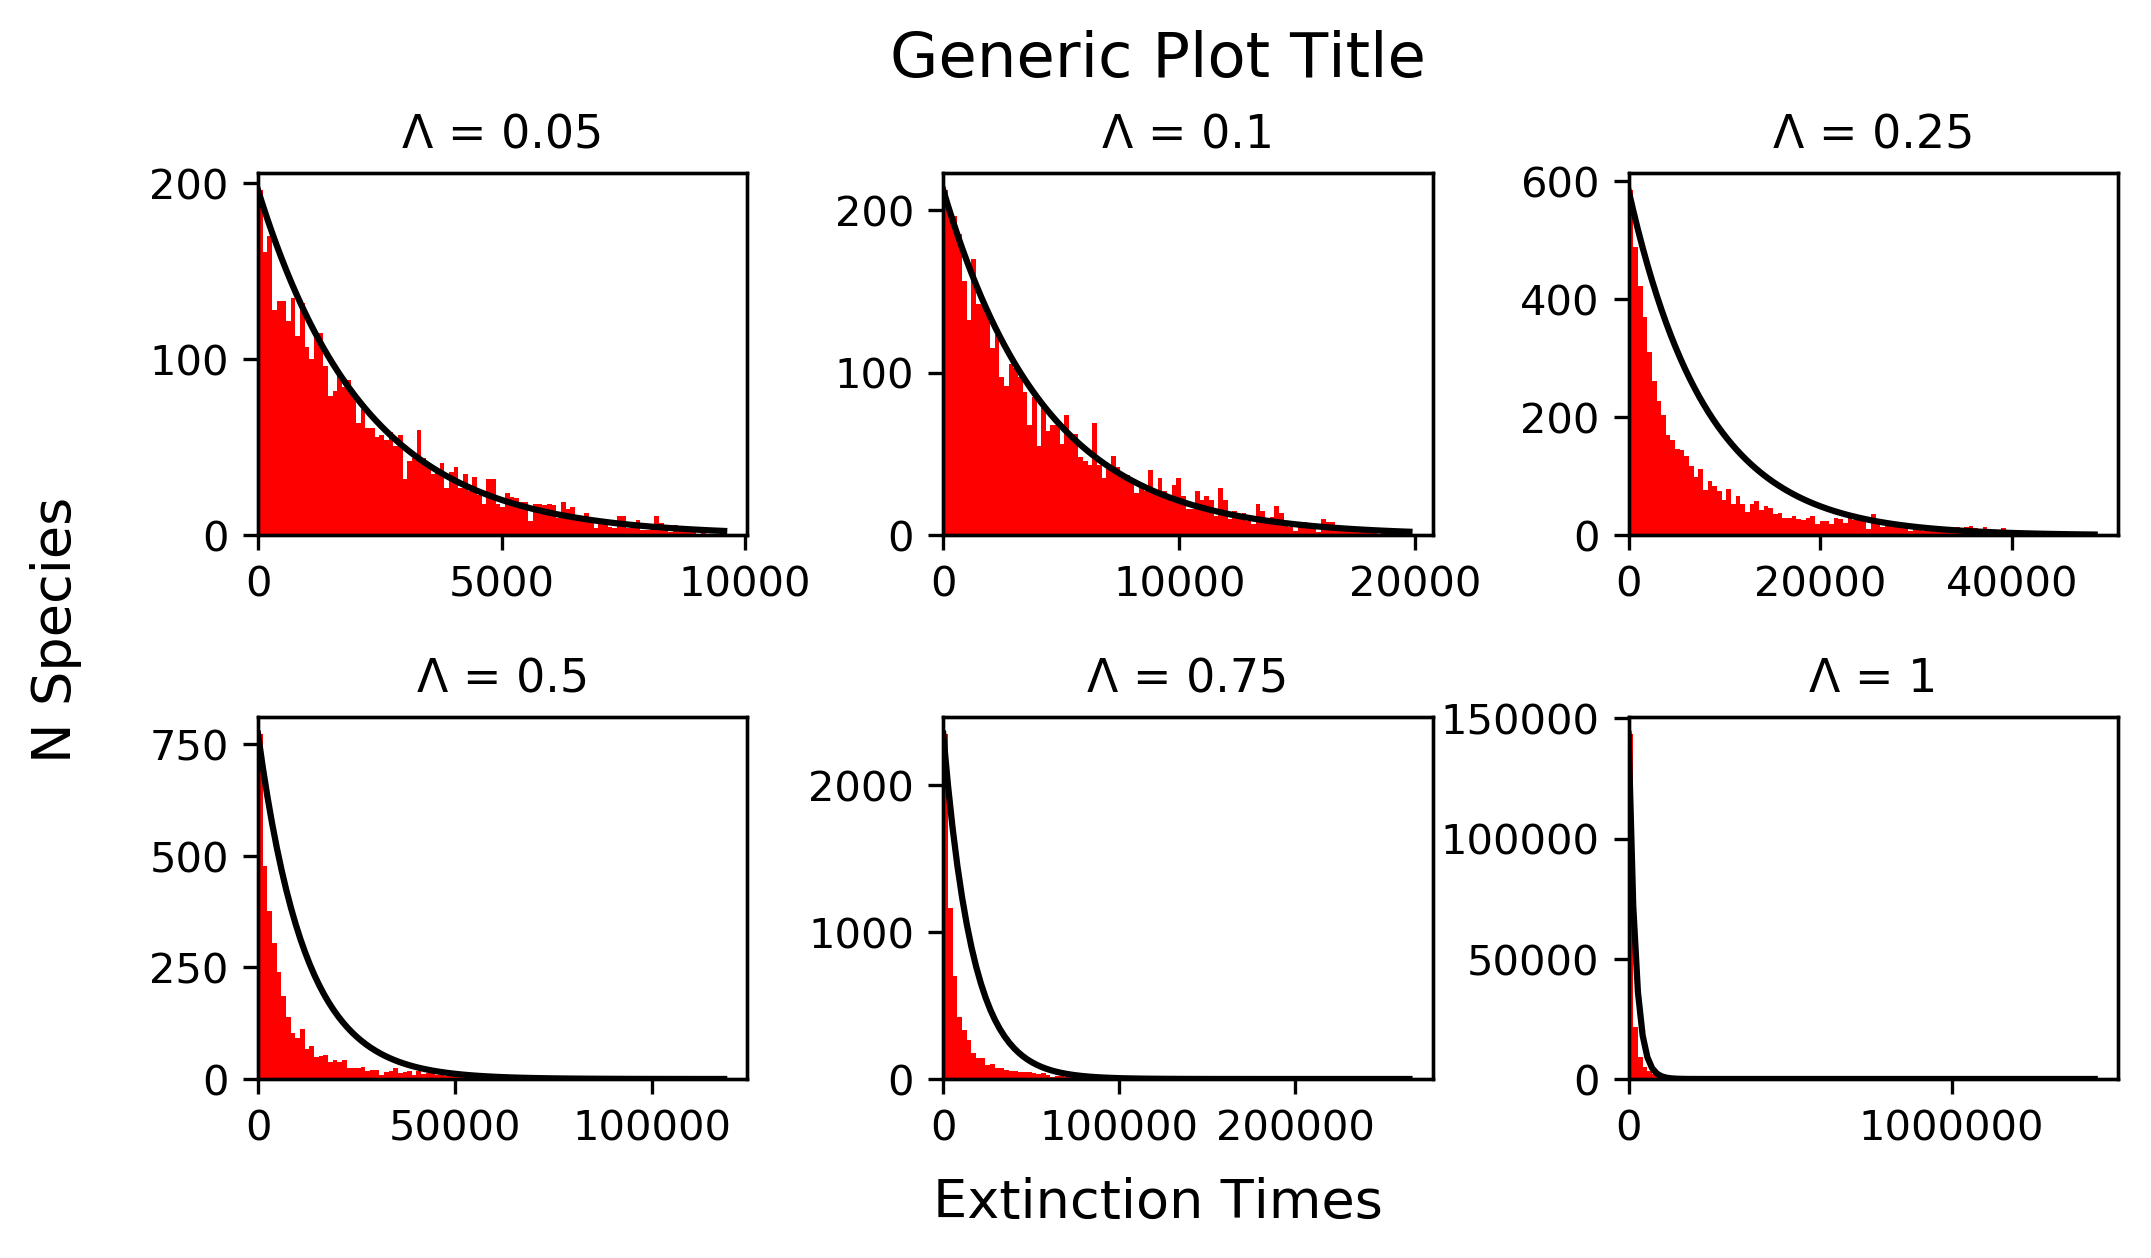

In [50]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend(line[1:])
    lambda_dists[percent] = coltimes#[:50000]
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n exttimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),
print("\n")
## Plot
plot_pidxy_per_lambda(lambda_dists, "Extinction Times", nbins=100, normed=False, sharey=False, sharex=False, \
                      zoom_x=1, do_expon=True, semilogx=False, semilogy=False)

## Testing plotting shannon's on binned pi x dxy

Got n coltimes per lambda:
0.25 - 5355	0.5 - 7960	0.05 - 3985	0.1 - 3874	1 - 17892	0.75 - 7986	

Median
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 0.0)
IQR
(0.0, 0.00035087719298245617)
(0.0, 0.00035087719298245617)
(0.0, 0.00035087719298245617)
(0.0, 0.00062378167641325539)
(0.0, 0.00062378167641325539)
(0.0, 0.00070175438596491234)
Mean
(1.4321518080916579e-05, 0.00016947787282715513)
(3.8986354775828475e-05, 0.0001976580923949345)
(8.1540088420033389e-05, 0.00029342361752334053)
(0.00011505729092378644, 0.00037472321580650649)
(0.00015902806110884449, 0.00042319688109161799)
(0.00016226265251606382, 0.00047977802363767275)
Standard Deviation
(6.9426134728483072e-05, 0.00042211982527821706)
(0.0001463925916011223, 0.00049067536876554174)
(0.00020217944671407874, 0.00067590244762765481)
(0.00028919452160669842, 0.00081045404804493842)
(0.00031052483385530551, 0.0010680542703487622)
(0.00033735368743085842, 0.0015576281008165104)
Skewness
(1.764413676282435, 7.7059514

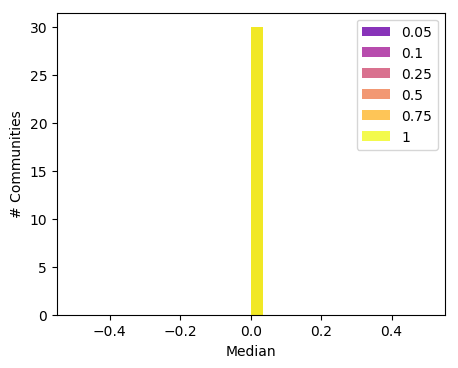

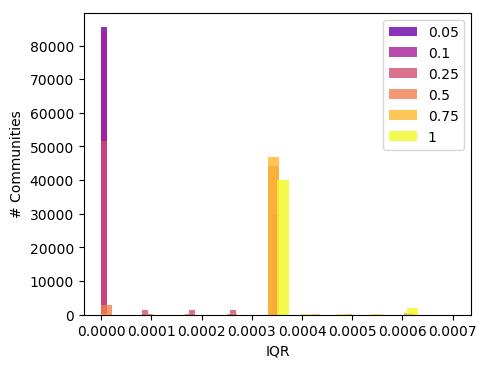

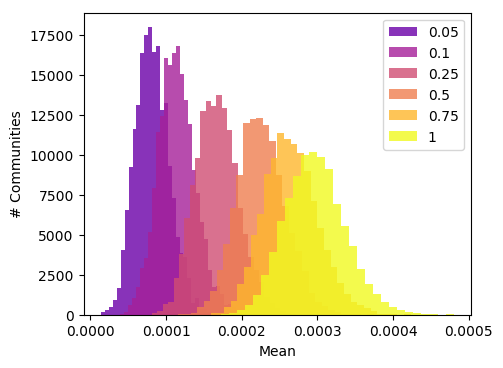

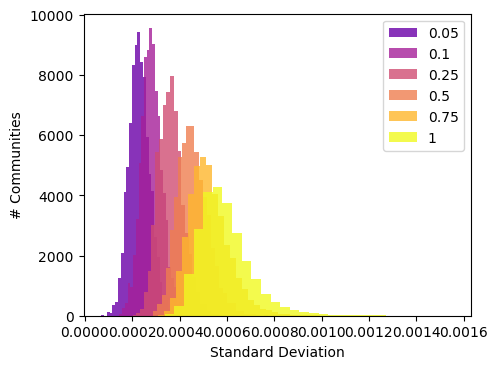

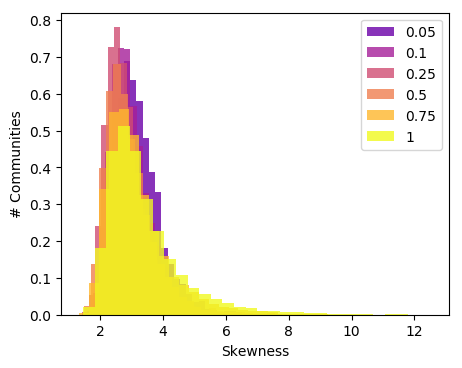

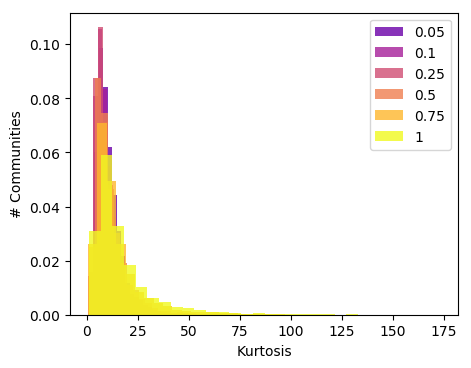

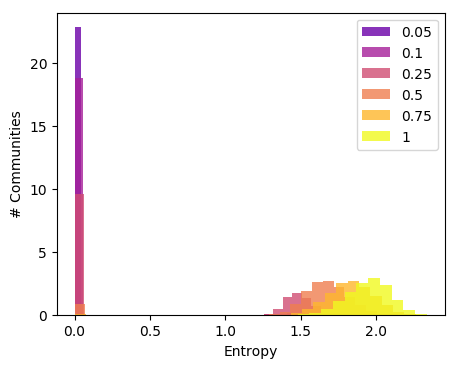

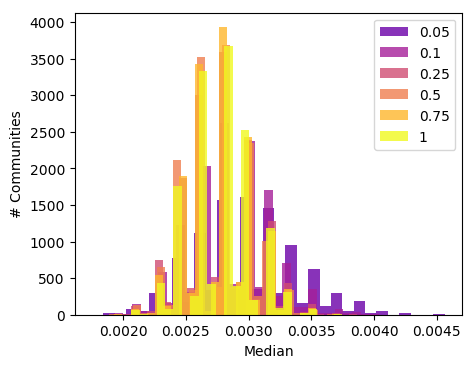

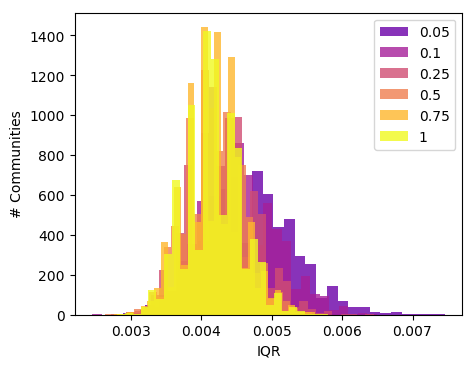

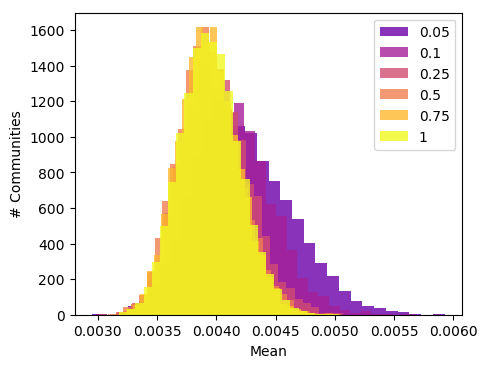

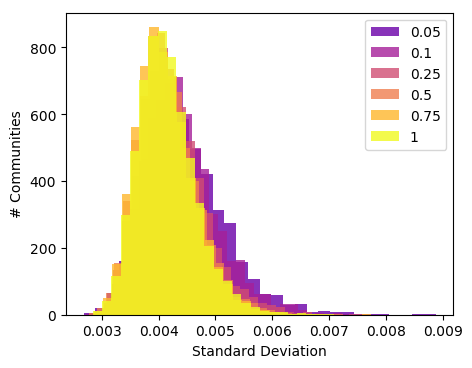

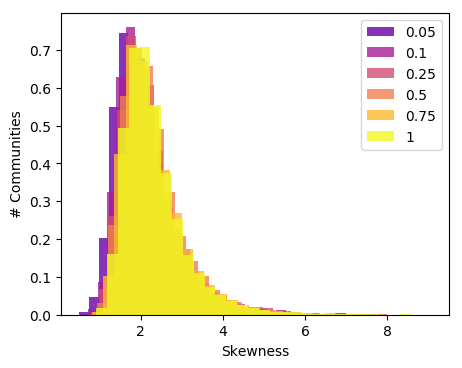

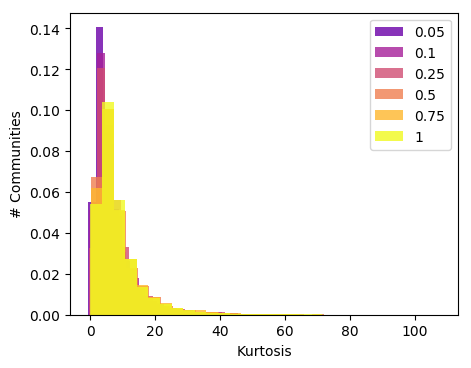

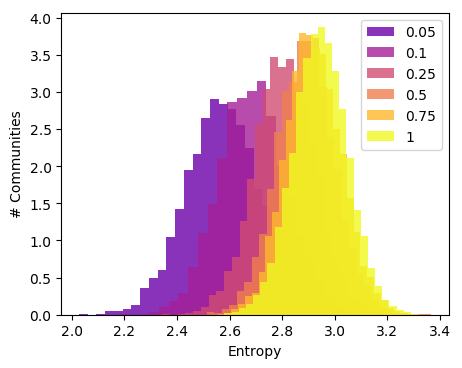

In [29]:
time_tolerance = 0.03
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

def shan(vec):
    hist, edges = np.histogram(vec, bins="auto")
    entropy = 0
    tot = sum(hist)
    for b in hist:
        if b > 0:
            p_x = float(b)/tot
            entropy += - p_x*math.log(p_x, 2)
    return entropy

def plot_pi_dxy_H(lambda_dists, sumstat_name):
    ## Calculate shanon's for each sampled community within each timepoint
    
    for label, func in zip(["Median", "IQR", "Mean", "Standard Deviation", "Skewness", "Kurtosis", "Entropy", "Shannon"], \
                           [np.median, scipy.stats.iqr, np.mean, np.std, scipy.stats.skew, scipy.stats.kurtosis, shan]):
        print(label)
        f, ax = plt.subplots(1, figsize=(5,4), dpi=100)
        ## Set up the colors
        gradient = np.linspace(0.2, 1, 6)
        #cm = plt.cm.get_cmap('plasma')
        cm = plt.cm.get_cmap('plasma')
        for i,l in enumerate(sampling_lambdas):
            dat = [func(x) for x in lambda_dists[l]]
            print(min(dat), max(dat))
            try:
                ax.hist(dat, normed=True, label=[l], color=cm(gradient[i], alpha=0.8), bins=30)
            except:
                pass
            ax.legend()
            ax.set_xlabel(label)
            ax.set_ylabel("# Communities")
            #ax.set_title("{} {} for varying values of Λ".format(label))

########################################

## Dict for storing distributions per timepoint
for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
    lambda_dists = {perc:[] for perc in sampling_lambdas}
    ## Ineffecient but i don't care
    for percent in sampling_lambdas:
        coltimes = []
        for line in dat:
            if len(line) < 10:
                ## bad data
                continue
            ## If the difference between the lambda for each line
            ## is close enough to the sampling lambda we want then keep the coltimes
            if abs(line[0] - percent) < time_tolerance:
                m = np.array(line[2:])
                p = m[m<0.1]
                coltimes.append(p)
        lambda_dists[percent] = coltimes#[:275]
        #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
    print("Got n coltimes per lambda:")
    for k,v in lambda_dists.items():
        print("{} - {}\t".format(k, len(v))),
    print("\n")
    ## Plot
    if "pi" in g:
        plot_pi_dxy_H(lambda_dists, u"π")
    else:
        plot_pi_dxy_H(lambda_dists, u"$\mathregular{D_i}$")

In [277]:
import math
def shan(hist):
    entropy = 0
    tot = sum(hist)
    for b in hist:
        if b > 0:
            p_x = float(b)/tot
            entropy += - p_x*math.log(p_x, 2)
    return entropy
            
tmp = lambda_dists[0.25][10]
bins, edges = np.histogram(tmp, bins=30)

print(shan(bins))
print(bins)
print(edges)

2.77412055701
[60 39 29 11  4  6 10  7  2  3  0  2  1  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  1]
[ 0.          0.00154386  0.00308772  0.00463158  0.00617544  0.0077193
  0.00926316  0.01080702  0.01235088  0.01389474  0.0154386   0.01698246
  0.01852632  0.02007018  0.02161404  0.02315789  0.02470175  0.02624561
  0.02778947  0.02933333  0.03087719  0.03242105  0.03396491  0.03550877
  0.03705263  0.03859649  0.04014035  0.04168421  0.04322807  0.04477193
  0.04631579]


# **Shannon**
## Grab all the data from the sumstats file

In [306]:
files = glob.glob(SIMOUT_DIR + "*5000*/sumstats.txt")
dat = []
for f in files:
    lines = open(f).readlines()[1:]
    new_lines = []
    for line in lines:
        try:
            ## Parse each line and get rid of bracket characters
            d = [float(x) for x in line.strip().split()]
            ## 3 - lambda
            ## 4/5 - col/ext rates
            ## 6 - Shannon
            l = d[3:7]
            new_lines.append(l)
        except Exception as inst:
            print(inst)
    dat.extend(new_lines)
print("Processed ntimepoints {}".format(len(dat)))
print(dat[:1])

Processed ntimepoints 337861
[[0.0064, 0.0046, 0.0023, 0.835894813218]]


Got n coltimes per lambda:
0.25 - 16820	0.5 - 25491	0.05 - 13259	0.1 - 13905	1 - 12890	0.75 - 25784	

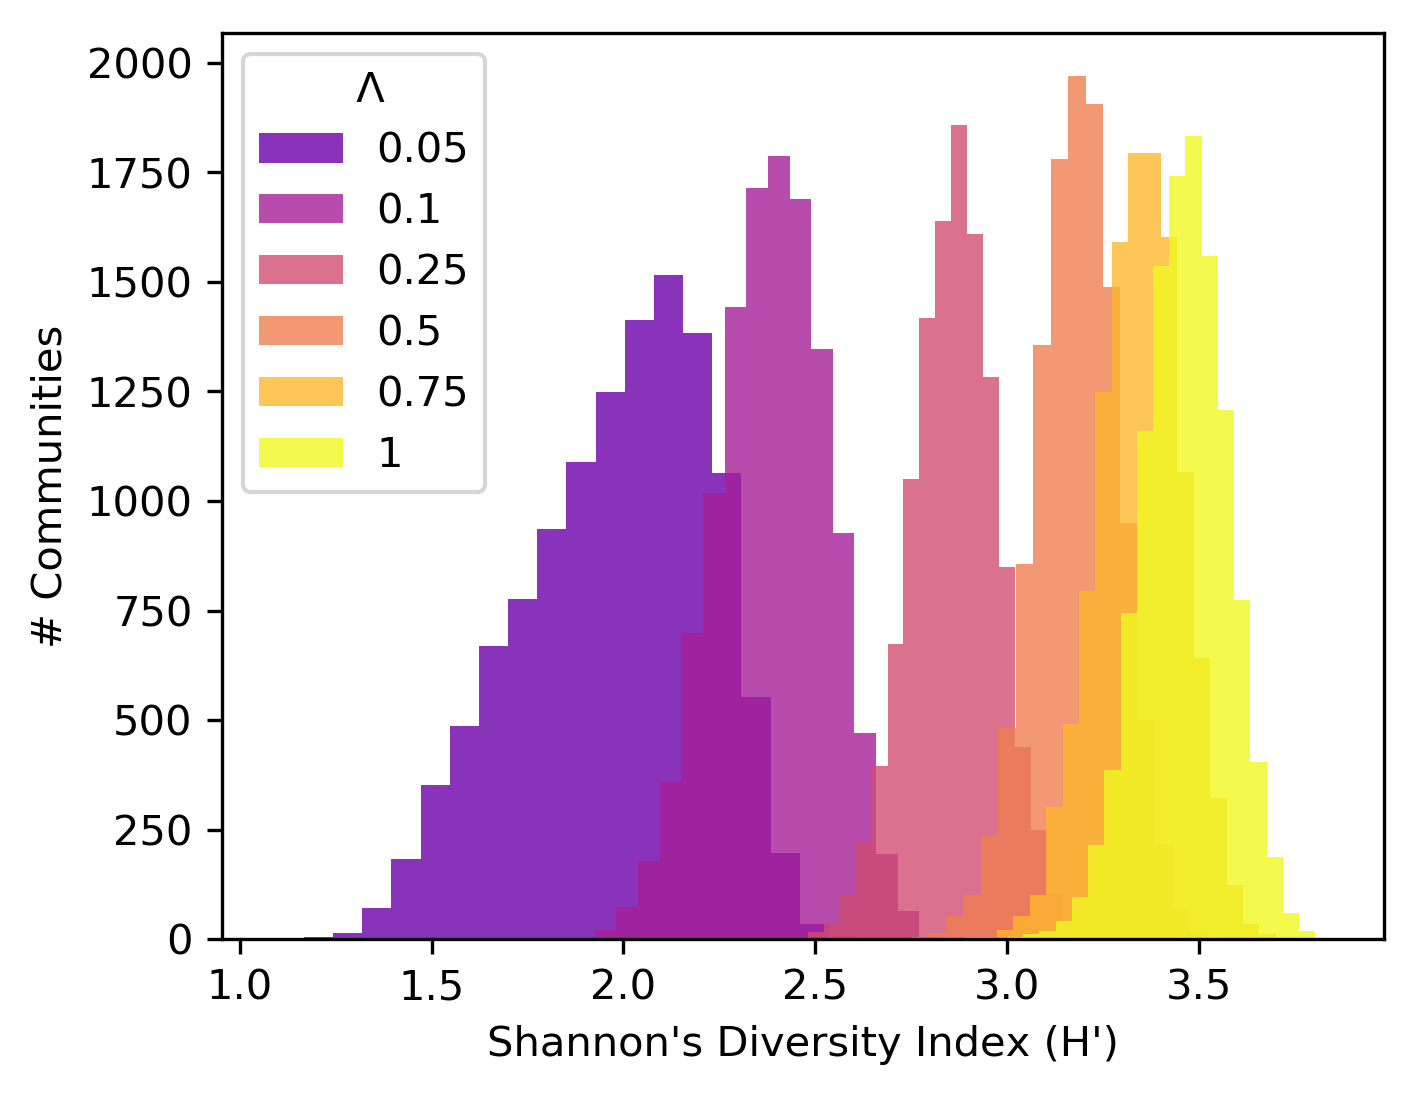

In [309]:
import matplotlib as mpl
mpl.rc('font',family='Times New Roman') 

max_samps = 12000
time_tolerance = 0.03
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            coltimes.extend([line[3]])
    lambda_dists[percent] = coltimes
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),

## Plot
f, ax = plt.subplots(1, figsize=(5,4), dpi=300)
## Set up the colors
gradient = np.linspace(0.2, 1, 6)
cm = plt.cm.get_cmap('plasma')
#cm = plt.cm.get_cmap('binary')
for i,l in enumerate(sampling_lambdas):
    ax.hist(lambda_dists[l][:max_samps], normed=False, label=[l], color=cm(gradient[i], alpha=0.8), bins=20)
    L = ax.legend(title=u" Λ")
    #plt.setp(L.texts, family='Times New Roman')
    ax.set_xlabel("Shannon's Diversity Index (H')")
    ax.set_ylabel("# Communities")
    #ax.set_title("Shannon's index through time")
plt.savefig("/home/isaac/gimmeSAD/ShannonThroughTime.svg")

# Extinction rate

Got n coltimes per lambda:
0.25 - 1446	0.5 - 2229	0.05 - 2160	0.1 - 1279	1 - 5975	0.75 - 2322	

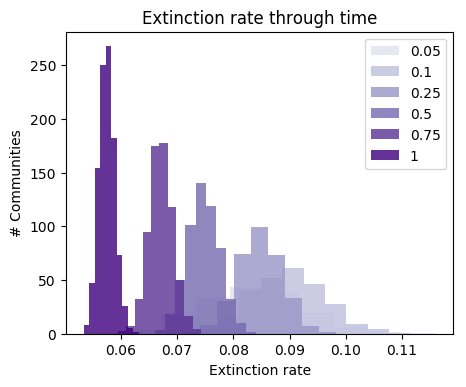

In [46]:
time_tolerance = 0.01
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

## Dict for storing distributions per timepoint
lambda_dists = {perc:[] for perc in sampling_lambdas}

## Ineffecient but i don't care
for percent in sampling_lambdas:
    coltimes = []
    for line in dat:
        ## If the difference between the lambda for each line
        ## is close enough to the sampling lambda we want then keep the coltimes
        if abs(line[0] - percent) < time_tolerance:
            #print(line)
            #coltimes.extend([line[1] - line[2]])
            coltimes.extend(np.array([line[2]])*10)
    lambda_dists[percent] = coltimes
    #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)

print("Got n coltimes per lambda:")
for k,v in lambda_dists.items():
    print("{} - {}\t".format(k, len(v))),

## Plot
f, ax = plt.subplots(1, figsize=(5,4), dpi=100)
## Set up the colors
gradient = np.linspace(0.2, 1, 6)
#cm = plt.cm.get_cmap('plasma')
cm = plt.cm.get_cmap('Purples')
for i,l in enumerate(sampling_lambdas):
    ax.hist(lambda_dists[l], normed=True, bins=10, label=[l], color=cm(gradient[i], alpha=0.8))
    ax.legend()
    ax.set_xlabel("Extinction rate")
    ax.set_ylabel("# Communities")
    ax.set_title("Extinction rate through time")

# Crap below here

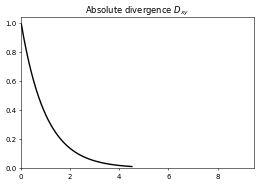

In [109]:
f, ax = plt.subplots(1,1, figsize=(6,4), dpi=50)
x = np.arange(expon.ppf(0.01), expon.ppf(0.99), .1)
rv = expon()
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
x0, x1 = ax.get_xlim()
y0, y1 = ax.get_ylim()
ax.set_xlim(0,x1*2)
ax.set_ylim(0,y1)
## Works
#ax.spines['left'].set_position(('axes', 0.03))
#ax.spines['right'].set_color('none')
#ax.spines['bottom'].set_position(('axes', 0.04))
#ax.spines['top'].set_color('none')
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
ax.set_title(r"Absolute divergence $D_{xy}$")

In [12]:
np.arange(int(min(coltimes)), int(max(coltimes)+1), step=int(max(coltimes)/5))

array([      1,  500000,  999999, 1499998, 1999997, 2499996])

In [ ]:
plot_pidxy_per_lambda(lambda_dists, "Average pairwise distance", nbins=100)

Got n coltimes per lambda:
0.25 - 950588	0.5 - 1603627	0.05 - 450787	0.1 - 557329	1 - 3957611	0.75 - 1700824	

Got n coltimes per lambda:
0.25 - 950588	0.5 - 1603627	0.05 - 450787	0.1 - 557329	1 - 3957611	0.75 - 1700824	



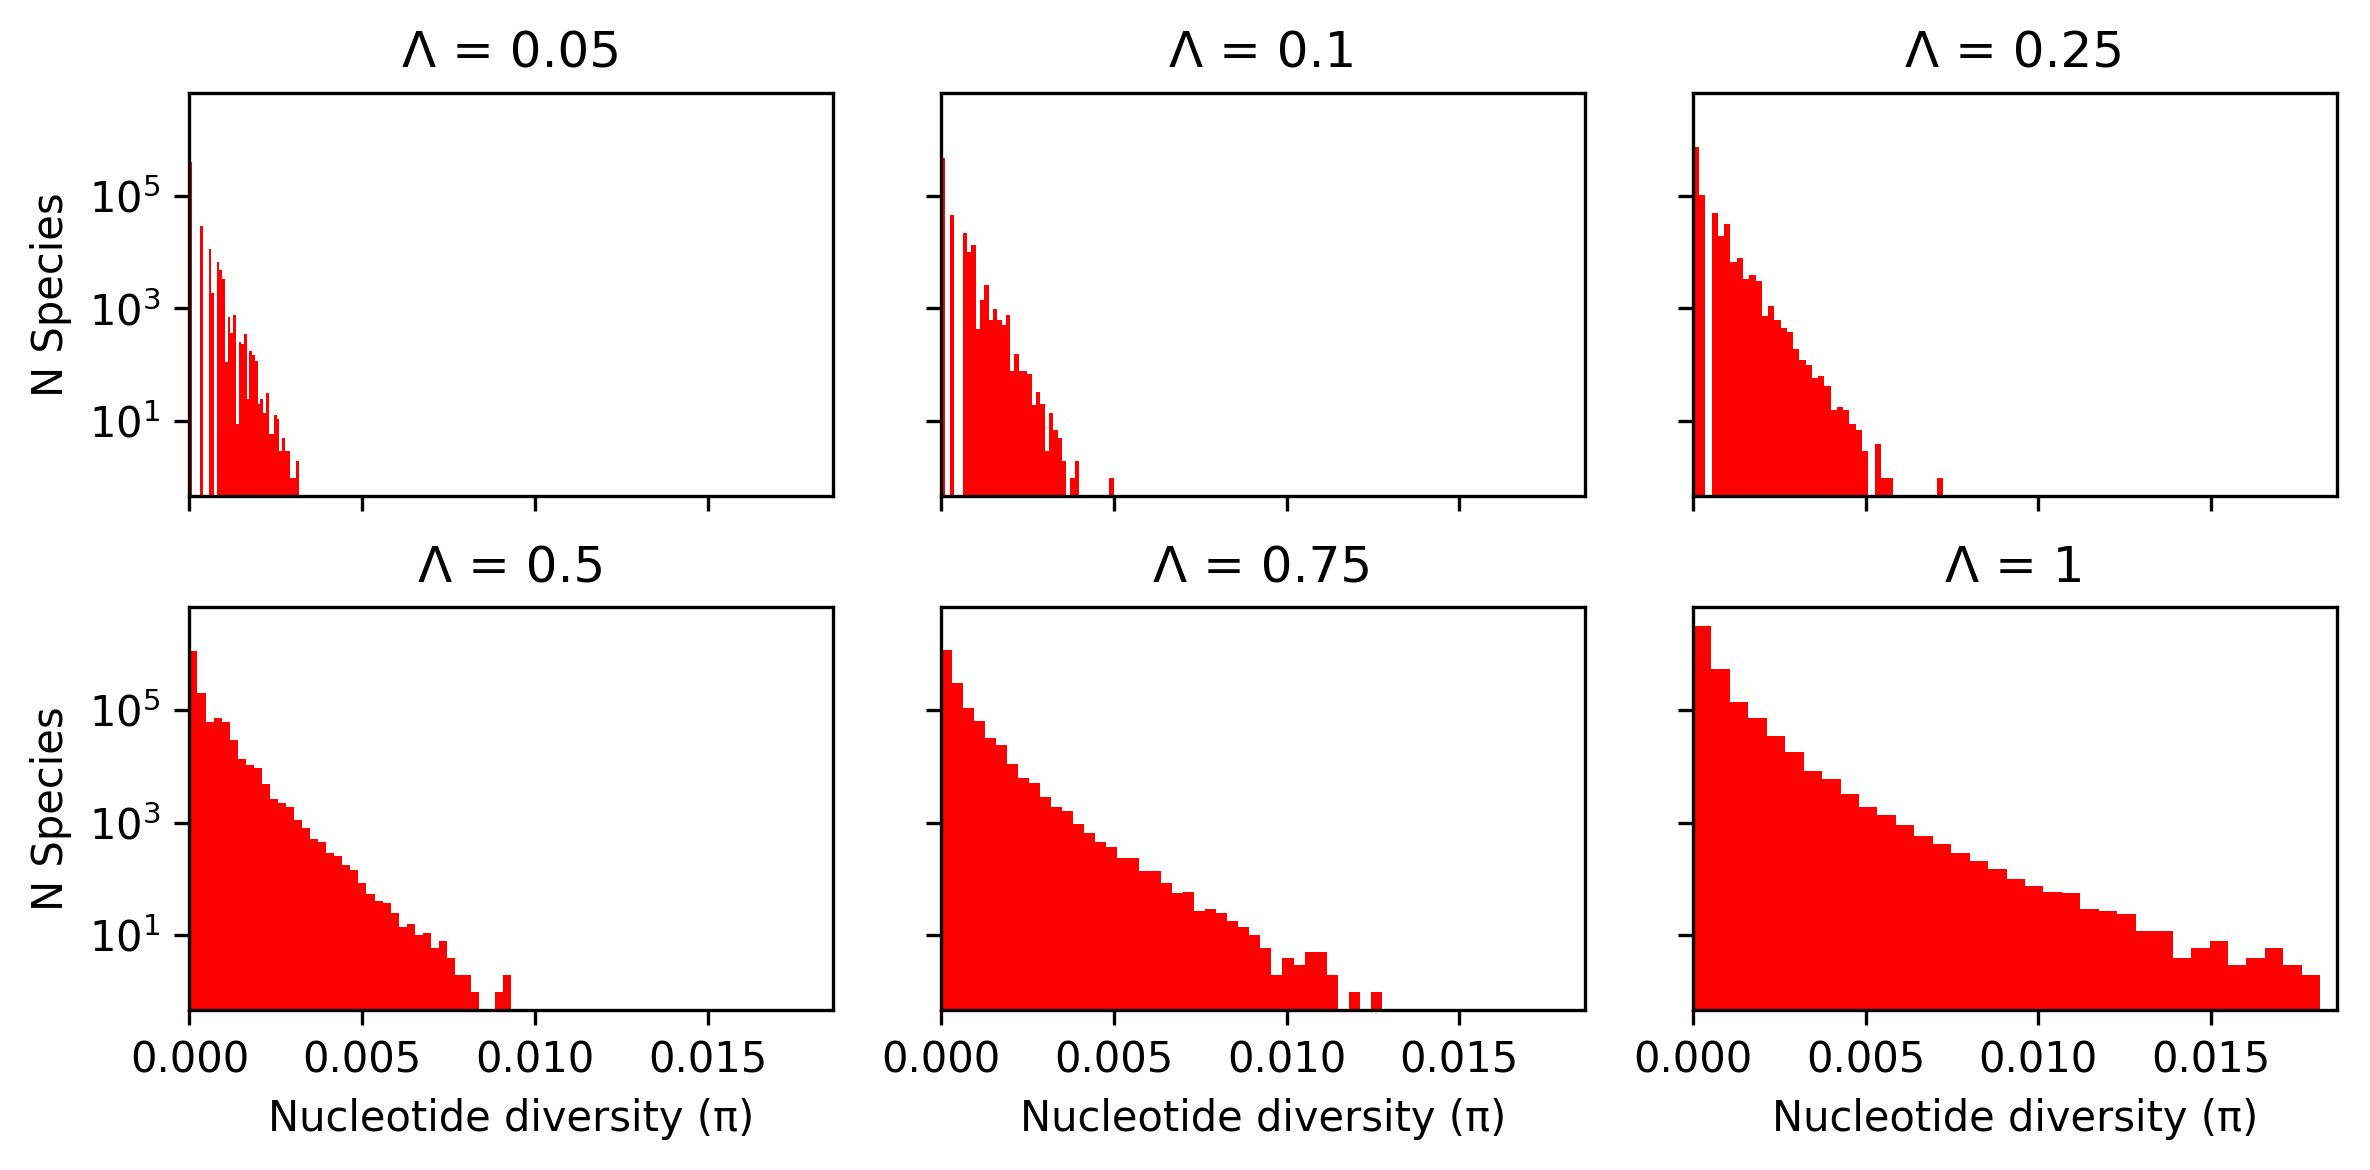

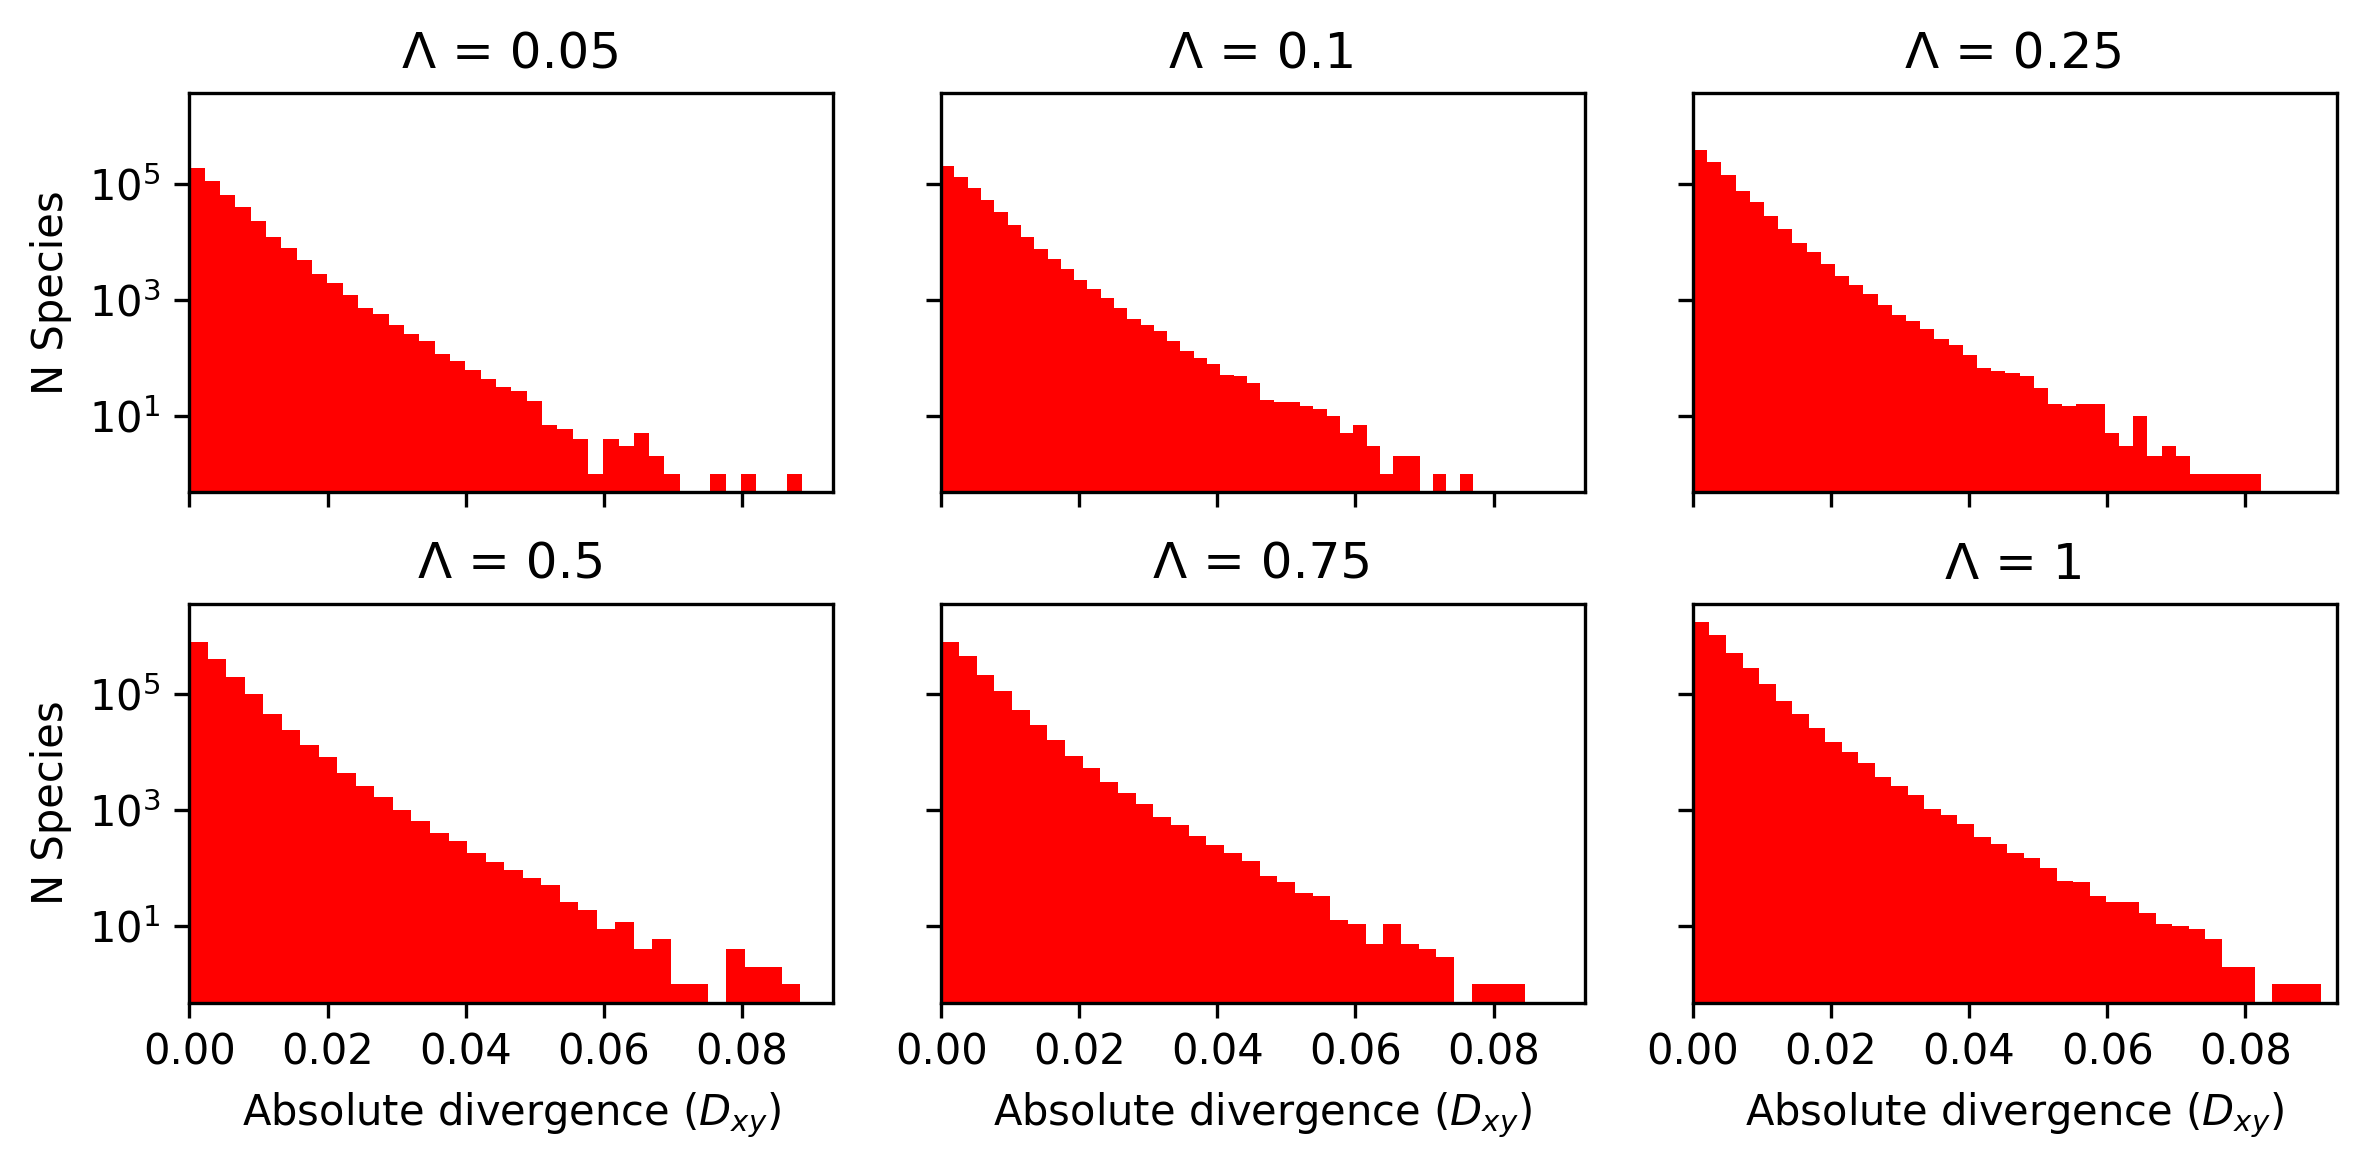

In [64]:
time_tolerance = 0.03
sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]

pi_dists = {}
dxy_dists = {}
## Dict for storing distributions per timepoint
for g, dat in {"pi":pi_dat, "dxy":dxy_dat}.items():
    lambda_dists = {perc:[] for perc in sampling_lambdas}
    ## Ineffecient but i don't care
    for percent in sampling_lambdas:
        coltimes = []
        for line in dat:
            ## If the difference between the lambda for each line
            ## is close enough to the sampling lambda we want then keep the coltimes
            if abs(line[0] - percent) < time_tolerance:
                m = np.array(line[2:])
                p = m[m<0.2]
                p = p[p>=0]
                coltimes.extend(p)
        lambda_dists[percent] = coltimes#[:100000]
        #lambda_dists[percent] = np.random.choice(coltimes, 12000, replace=False)
    print("Got n coltimes per lambda:")
    for k,v in lambda_dists.items():
        print("{} - {}\t".format(k, len(v))),
    print("\n")
    ## Plot
    if "pi" in g:
        pi_dists = lambda_dists
        plot_pidxy_per_lambda(lambda_dists, u"Nucleotide diversity (π)", nbins=40, normed=False, sharey=True, \
                              zoom_x=.75, semilogx=False, semilogy=True, do_expon=False)
    else:
        dxy_dists = lambda_dists
        plot_pidxy_per_lambda(lambda_dists, r"Absolute divergence ($D_{xy}$)", nbins=40, normed=False, sharey=True, \
                              zoom_x=1, semilogx=False, semilogy=True, do_expon=False)

In [86]:
import fastkde

sampling_lambdas = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for k,v in lambda_dists.items():
    myPDF,axes = fastkde.pdf(v)

    #Extract the axes from the axis list
    v1,v2 = axes

    

AttributeError: 'module' object has no attribute 'pdf'

# Salvage the files that had double equilibrium resetting lambda to zero.

In [435]:
## Clean the simulations
workdir = "/home/isaac/gimmeSAD/deme_size_sims/"
files = ["abundances.txt", "coltimes.txt", "pidxy.txt"]

# Don't run this accidentally
#for f in files:
    print("Doing {}".format(f))
    allf = glob.glob(workdir+"*/"+f)
    print("Numfiles {}".format(len(allf)))
    for tmpfile in allf:
            print(tmpfile)
            out = []
            lines = open(tmpfile).readlines()
            lamb = 0
            for line in lines:
                if abs(float(line.split()[0]) - lamb) < 0.7:
                    lamb = float(line.split()[0])
                    out.append(line)
                else:
                    out.append("1 "+ line.split(" ", 1)[1])
                    break
            with open(tmpfile, 'w') as outfile:
                outfile.write("".join(out))


Doing abundances.txt
Numfiles 216
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831849.15_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509733441.1_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915102.72_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733440.98_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733430.27_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915105.76_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509915102.74_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509831846.35_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917687.97_x4/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509831846.29_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831848.61_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-15098

/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509915105.82_x10/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733440.95_x1/abundances.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733441.27_x4/abundances.txt
Doing coltimes.txt
Numfiles 216
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831849.15_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509733441.1_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915102.72_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733440.98_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509733430.27_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509915105.76_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509915102.74_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509831846.35_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917687.97_x4/coltim

/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509831846.34_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509915102.73_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509917687.98_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733441.6_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509915102.74_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917691.68_x10/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509831848.63_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509917687.97_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509733430.34_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509733430.22_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509831848.64_x1/coltimes.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733430.24_x4/coltimes.txt
/home/isaac/gimmeSAD/deme_si

/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831848.61_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.01-1509831849.12_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509915105.58_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509733441.65_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509915105.58_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509915102.74_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509733430.61_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831846.1_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509733430.31_x4/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509917691.41_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509733441.17_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509917691.42_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509733441.55

/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509831849.05_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509831846.13_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.005-1509733430.19_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.01-1509733430.44_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509917691.62_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.005-1509915105.79_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509733441.7_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.01-1509733430.21_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831846.35_x10/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.005-1509915102.71_x1/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_10000-C_0.03-1509831846.25_x4/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_5000-C_0.03-1509831848.92_x4/pidxy.txt
/home/isaac/gimmeSAD/deme_size_sims/K_1000-C_0.03-1509917691.51_x

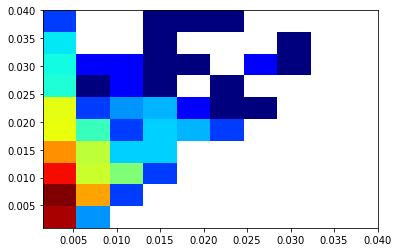

In [444]:
k = 0.75
#pi_dists
hist, _, _, im = plt.hist2d(pi_dists[k][:20000], dxy_dists[k][:20000], bins=10, cmap=cmap, norm=LogNorm(), normed=False, range=rang)

[[ 138.   81.   15.    9.    2.    3.    0.    0.    0.    0.]
 [   2.   17.   13.    5.    2.    1.    0.    0.    0.    0.]
 [   0.    2.   14.    7.    0.    1.    0.    1.    0.    0.]
 [   0.    0.    2.    6.    3.    1.    0.    1.    0.    0.]
 [   0.    0.    0.    1.    0.    0.    0.    1.    1.    0.]
 [   0.    0.    0.    0.    2.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    1.    2.    1.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    1.    1.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    1.    0.]]


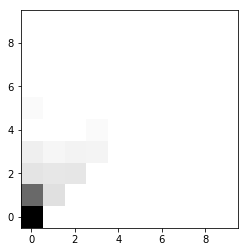

In [436]:
#0.05
#wat = hist[hist<200]
print(hist)
wat = hist
wat[wat<3] = 0
wat = wat.T

#plt.imshow(dat, cmap="binary", origin="lower")
plt.imshow(wat, cmap="binary", origin="lower")

[[ 154.   85.   26.    4.   10.    2.    2.    2.    0.    1.]
 [   3.   29.   23.   11.    1.    1.    0.    0.    1.    0.]
 [   0.    7.   16.    5.    1.    2.    2.    1.    0.    0.]
 [   0.    0.    1.    3.    1.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    1.    3.    1.    0.    1.    0.    0.]
 [   0.    0.    0.    0.    1.    3.    1.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    1.    0.    0.]
 [   0.    0.    0.    0.    0.    1.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    3.    0.    0.]
 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.]]


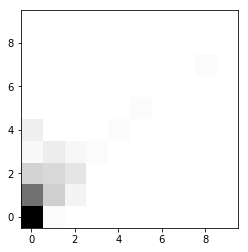

In [441]:
#0.1
#wat = hist[hist<200]
print(hist)
wat = hist
wat[wat<3] = 0
wat = wat.T
dat = hist.T

plt.imshow(dat, cmap="binary", origin="lower")
plt.imshow(wat, cmap="binary", origin="lower")

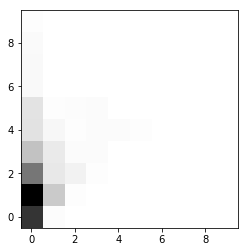

In [445]:
#0.75
#wat = hist[hist<200]
wat = hist
wat[wat<3] = 0
wat = wat.T
dat = hist.T

plt.imshow(dat, cmap="binary", origin="lower")
plt.imshow(wat, cmap="binary", origin="lower")